___

> ### Green HPC: An analysis of the domain based on Top500 - experiments

____

In [1]:
# Imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import numpy as np

from typing import List
from scipy.optimize import curve_fit

In [2]:
# to remove warnings
warnings.filterwarnings('ignore')

# Power : KW
# Rmax/Rpeak : GFlops
# Energy efficiency : Gflops/Watts

In [3]:
# Some useful functions to:
## filter data:
def read_filter_top500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific top500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    file_path = f"./data/top500/TOP500_{y}{m}.xls{'x'*min(1, max(0, y-2019))}"
    df_f = pd.read_excel(
            file_path, 
            header=1 - min(1, max(0, y - 2007))
        )
    # truncating by range
    df_f = df_f.iloc[:range]

    # some data cleaning + scaling (Tflops to Gflops)
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y > 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y > 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000 
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))

    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']
    df_f.loc[df_f['perf_percent'] > 1, 'RPeak'] *= 10
    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']
    
    # choosing the fields of interest 
    df_f = df_f[fields]

    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])
    
    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/output_data/TOP500_{y}{m}.csv')
    
    return df_f

def read_filter_green500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific Green500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    df_f = pd.read_excel(f"./data/green500/#green500_{y}_{m}.xlsx", header=0)

    # truncating by range
    df_f = df_f.iloc[:range]

    # homogenising the fields
    if y == 2014 and m == '06':
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
    elif y == 2015:
        df_f['TOP500 Rank'] = df_f['top500_rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
        df_f['Power'] = df_f['total_power']
    elif y == 2016 and m == '06' or (y == 2014 and m == '11'):
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
        df_f['Rank'] = df_f['Green500_Rank']
    elif y == 2016 and m == '11':
        df_f['TOP500 Rank'] = df_f['Rank']
        df_f['Rank'] = df_f['Green500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
    elif y < 2020:
        df_f['G_eff'] = df_f['Power Effeciency [GFlops/Watts]']
    elif y < 2022:
        df_f['G_eff'] = df_f['Power Efficiency [GFlops/Watts]']
    else:
        df_f['G_eff'] = df_f['Energy Efficiency [GFlops/Watts]']
    
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y> 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y >= 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
            df_f['Power'] = df_f['Power (kW)']
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))
    
    # choosing the fields of interest
    df_f = df_f[fields]
    
    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])
    # performance percentage
    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']
    df_f.loc[df_f['perf_percent'] > 1, 'RPeak'] *= 10
    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']

    # HPC type (heterogeneous / homogeneous:
    df_f['Accelerator/Co-Processor'] = list(df_f['Accelerator/Co-Processor'].notnull().astype('int'))


    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/output_data/GREEN500_{y}{m}.csv')

    return df_f


## calculate apparitions:
def calc_apparition(l: List, unit: str = 'y'):
    """Calculates the apparition time of an HPC in the top500 list by years/months.
    
    Args:
        l (list): the list of apparition dates.
        unit (str): output unit.
        
    Returns:
        the apparition time in the chosen unit.
    """
    c = 0
    dates = []
    for el in l:
        if el[1] in dates:
            l.remove(el)
            continue
        dates.append(el[1])
        c+=1

    # return the apparition time 
    if unit == 'y':
        return c * 6 / 12

    return c

## calculate other values ...
def exp_funct(x: float, a: float, b: float):
    """Calculates the exp."""
    return a * np.power(np.exp(x), b)

def moore_funct(x: float, df: pd.DataFrame, metric: str = "RMax"):
    """Calculates moore's prediction."""
    return df.iloc[0][metric] * 2 ** (x/4)

def koomey_funct(x: float, df: pd.DataFrame, y: float = 0, metric: str = "G_eff"):
    """Calculates koomey's prediction."""
    return df.iloc[y][metric] * 2 ** ((x-y)/3)


In [4]:
# Our fields of interest.
main_fields = ['Computer', 'Year', 'Country', 'Cores', 'Rank', 'Site', 'RMax', 'RPeak']
main_green_fields = ['Computer', 'Year', 'Country', 'Cores', 'Site', 'Power',
                     'RMax', 'RPeak', 'TOP500 Rank', 'Rank', 'Accelerator/Co-Processor', 'G_eff']
# concatenate all the extracted dataframes into one single one from the year 1993 to 2023.
concat_df = pd.concat(
        [read_filter_top500_data(y, m, range=500, fields=main_fields) 
        for y in range(1994, 2023) for m in ['06', '11']], ignore_index=True
    )

green_concat_df = pd.concat(
        [read_filter_green500_data(y, m, range=100, fields=main_green_fields) 
        for y in range(2014, 2023) for m in ['06', '11']], ignore_index=True
    )

# some info about the concatenated dataframe
concat_df.info()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

In [5]:
# adding a minimum rank column.
tmp_fields = list(main_fields)
tmp_fields.remove('Rank')

concat_df['min_rank'] = concat_df[main_fields].groupby(tmp_fields).transform('min')
green_concat_df['g_min_rank'] = green_concat_df[tmp_fields + ['TOP500 Rank']].groupby(tmp_fields).transform('min')

# visualizing the output
concat_df.tail()


,Computer,Year,Country,Cores,Rank,Site,RMax,RPeak,rank_year,min_rank
28995,"Sugon TC6000, Xeon Gold 5118 12C 2.3GHz, 10G E...",2018,China,97920,496,Telecom Operator (C),1736000.0,7206912.0,2022-11,306
28996,"ThinkSystem Flex SN550, Xeon Gold 6150 18C 2.7...",2018,China,32400,497,Government,1735660.0,2799360.0,2022-11,117
28997,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,498,Internet Service A,1729000.0,3072000.0,2022-11,95
28998,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,499,Internet Service A,1729000.0,3072000.0,2022-11,95
28999,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,500,Internet Service A,1729000.0,3072000.0,2022-11,95


Avg shelflife: 1.40 | Max shelflife: 11.50 | Min shelflife: 0.50.  [+/- 0->6 months]


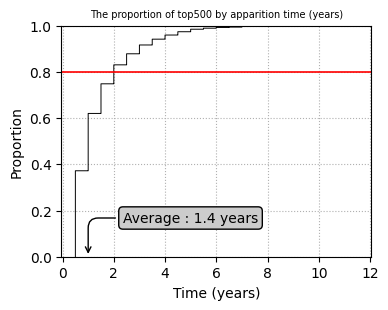

In [6]:
# plotting: The proportion of top500 by apparition time (years)
## plot settings
offset = 50
plt.figure(figsize=(4, 3))
plt.grid(linestyle='dotted')
plt.title('The proportion of top500 by apparition time (years)', fontsize=7)

## data reformatting
g_df = concat_df.copy(deep=True)
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list)

# plotting the data
ax = sns.ecdfplot(data=g_df.reset_index()['rank_year'].apply(calc_apparition), color='black', linewidth=0.7)

# axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Proportion')

# Apparition time [mean, max, min]
minimum, average, maximum = g_df.apply(calc_apparition).min(), g_df.apply(calc_apparition).mean(), g_df.apply(calc_apparition).max()
print(
    "Avg shelflife: {0:.2f} | Max shelflife: {1:.2f} | Min shelflife: {2:.2f}.  [+/- 0->6 months]".format(
        average,
        maximum,
        minimum
        )
    )

# addiung an arrow to point out the average
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

ax.annotate(
        f'Average : {average:.1f} years',
        xy=(1, 0), 
        xytext=(0.5*offset, 0.5*offset), textcoords='offset points',
        bbox=dict(boxstyle="round", fc="0.8"), arrowprops=arrowprops
    )

# highlighting the 80% proportion threshold
plt.axhline(y = 0.8, color = 'r', linewidth=1.2)

plt.savefig("./figures/top500_lifespan.png", format='png', bbox_inches="tight")


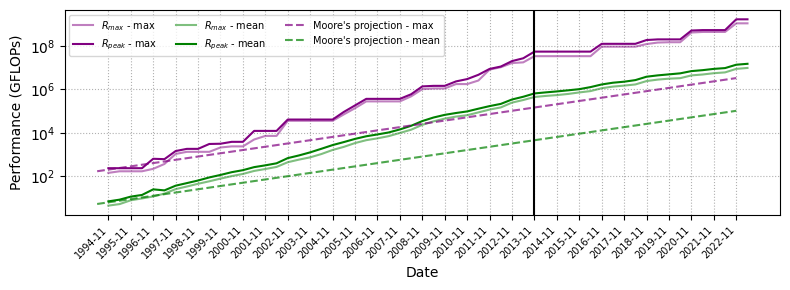

In [7]:
# Plotting : The maximum (and mean) Rmax Evolution of the Top500 supercomputers over time, along with Moore’s law projections
## plot settings
plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted') 
plt.yscale('log')

## mean & max df
log_df = concat_df.copy(deep=True)
log_df_mean = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').mean().reset_index()
log_df_max = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').max().reset_index()
log_df_mean['index'] = log_df_max.index + 1
log_df_max['index'] = log_df_mean.index + 1

## The mean and maximum plots of the Rmax value over time
sns.lineplot(data=log_df_max, x='index', y='RMax', label=r'$R_{max}$ - max', color='purple', alpha=0.5)
sns.lineplot(data=log_df_max, x='index', y='RPeak', label=r'$R_{peak}$ - max', color='purple')
sns.lineplot(data=log_df_mean, x='index', y='RMax', label=r'$R_{max}$ - mean', color='green', alpha=0.5)
sns.lineplot(data=log_df_mean, x='index', y='RPeak', label=r'$R_{peak}$ - mean', color='green')

## Curve fitting the maximum and mean Rmax values 
popt_max, _ = curve_fit(exp_funct, list(log_df_max['index'])[:40], list(log_df_max.RMax)[:40])
popt_mean, _ = curve_fit(exp_funct, list(log_df_mean['index'])[:40], list(log_df_mean.RMax)[:40])

## Plotting moore's projections 
plt.plot(
        [x for x in list(log_df_max.index)], [moore_funct(x, log_df_max) for x in list(log_df_max['index'])], 'g-', 
        label="Moore's projection - max".format(*popt_max), ls='dashed', color='purple', alpha=0.7
    )
plt.plot(
        [x for x in list(log_df_mean.index)], [moore_funct(x, log_df_mean) for x in list(log_df_mean['index'])], 'g-', 
        label="Moore's projection - mean".format(*popt_mean), ls='dashed', color='green', alpha=0.7
    )

plt.axvline(x = 39, color = 'black')

# Axis settings
plt.legend(ncol=3, loc=2,fontsize='7')
plt.xticks(
        rotation=45, ha='right', fontsize=7,ticks=np.arange(1, max(list(log_df_max['index'])), 2),
        labels=[list(log_df_max.rank_year)[i] for i in np.arange(1, max(list(log_df_max['index'])), 2)]
    )
plt.tight_layout()

plt.xlabel(r'Date')
plt.ylabel(r'Performance (GFLOPs)')

plt.savefig("./figures/top500_performance_evolution.png", format='png', bbox_inches="tight")

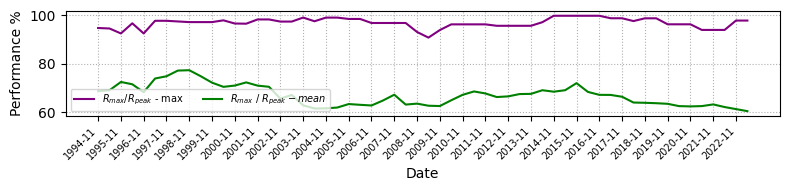

In [8]:
# Plotting : The performance ratio average between the Linpack Rmax and the theoretical Rpeak over time for the first Top500 system.
plt.figure(figsize=(8, 2))
plt.grid(linestyle='dotted') 

## mean & max df
log_df = concat_df.copy(deep=True)
log_df['perf_percent'] = (log_df['RMax']/log_df['RPeak'])
log_df.loc[log_df['perf_percent'] > 1, 'RPeak'] *= 10
log_df['perf_percent'] = 100 * log_df['RMax']/log_df['RPeak']

log_df_mean = log_df[['rank_year', 'RMax', 'RPeak', 'perf_percent']].groupby('rank_year').mean().reset_index()
log_df_max = log_df[['rank_year', 'RMax', 'RPeak', 'perf_percent']].groupby('rank_year').max().reset_index()
log_df_mean['index'] = log_df_max.index + 1
log_df_max['index'] = log_df_mean.index + 1

## The mean and maximum plots of the Rmax value over time
sns.lineplot(data=log_df_max, x='index', y='perf_percent', label=r'$R_{max}/R_{peak}$ - max', color='purple')
#
sns.lineplot(data=log_df_mean, x='index', y='perf_percent', label=r'$R_{max}$ / $R_{peak} - mean$', color='green')

# Axis settings
plt.legend(ncol=3, loc=3,fontsize='7')
plt.xticks(
        rotation=45, ha='right', fontsize=7,ticks=np.arange(1, max(list(log_df_max['index'])), 2),
        labels=[list(log_df_max.rank_year)[i] for i in np.arange(1, max(list(log_df_max['index'])), 2)]
    )
plt.tight_layout()

plt.ylabel(r'Performance %')
plt.xlabel(r'Date')

plt.savefig("./figures/performance_ratio.png", format='png', bbox_inches="tight")

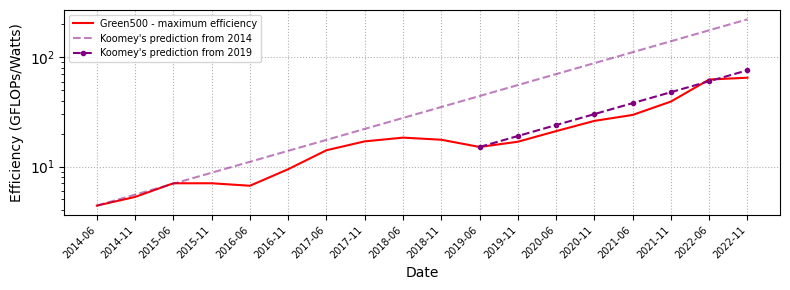

In [9]:
# Plotting: Maximum Efficiency of the Green500 supercomputers bylist date along with Koomey’s law projection starting at two different
# periods [2014 and 2019].

## plot parameters
plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted') 

green_log_df = green_concat_df.copy(deep=True)
green_log_df_max = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max()

tmp = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max().reset_index()

## plots
sns.lineplot(data=green_log_df_max, x='rank_year', y='G_eff', label='Green500 - maximum efficiency', color='red')
plt.plot(list(tmp.rank_year), [koomey_funct(x, df=tmp, metric='G_eff') for x in list(tmp.index)], 'g-', 
         label="Koomey's prediction from 2014".format(*popt_max), ls='dashed', color='purple', alpha=0.5)
plt.plot(list(tmp.rank_year[10:]), [koomey_funct(x, df=tmp, y=10, metric='G_eff') for x in list(tmp.index)[10:]], 'g.-', 
         label="Koomey's prediction from 2019".format(*popt_max), ls='dashed', color='purple')


## axis parameters
plt.yscale('log')
plt.xlabel(r'Date')
plt.ylabel(r'Efficiency (GFLOPs/Watts)')
plt.xticks(rotation=45, ha='right', fontsize=7)

plt.legend(ncol=1, loc=2, fontsize=7)
plt.tight_layout()

# to save the figure
plt.savefig("./figures/green500_efficiency_evolution.png",format='png', bbox_inches="tight")


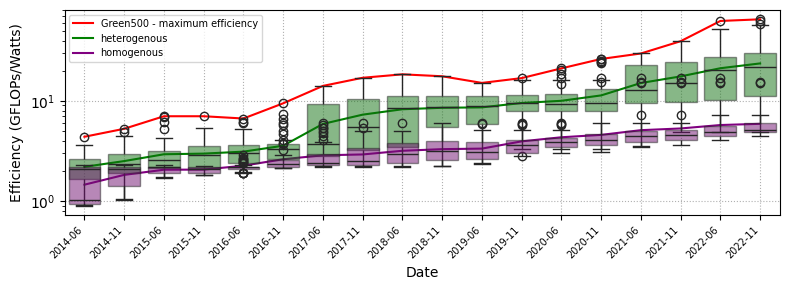

In [10]:
# Plotting: Maximum Energy efficiency growth Green500 systems by date distinguished by architecture type (homogeneous vs heteroge-
# neous)
plt.figure(figsize=(8, 3))

# machine type (heterogeneous / homogeneous)
g_gpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 1]
g_cpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 0]

# plots
sns.lineplot(data=green_concat_df.groupby('rank_year').max(), x='rank_year', y='G_eff', label='Green500 - maximum efficiency', color='red')
sns.lineplot(data=g_gpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', label='heterogenous', color='green')
sns.lineplot(data=g_cpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', label='homogenous', color='purple')

sns.boxplot(data=g_gpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', color='green',  boxprops=dict(alpha=.5))
sns.boxplot(data=g_cpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', color='purple',  boxprops=dict(alpha=.5))

# axis parameters
plt.yscale('log')
plt.xlabel(r'Date')
plt.ylabel(r'Efficiency (GFLOPs/Watts)')
plt.grid(linestyle='dotted') 
plt.legend(ncol=2, loc=9)
plt.xticks(rotation=45, ha='right', fontsize=7)

plt.legend(ncol=1, loc=2, fontsize=7)
plt.tight_layout()

# to save the fig
plt.savefig("./figures/green500_heterogeneity_vs_homogeneity.png", format='png', bbox_inches="tight")


In [11]:
# uploading the carbon intensity of each country by year for our next analysis
carbon_df = pd.read_csv('./data/carbon_intensity_by_country.csv')
carbon_df[carbon_df['Entity'] == 'France']
carbon_df['Country'] = carbon_df['Entity']

In [12]:
# Creating a copy of the previous dataframe
n_concat_df = green_concat_df.copy(deep=True)
n_concat_df = n_concat_df.merge(carbon_df, on=['Year', 'Country'])

# adding some useful columns for our analysis : electric consumption, carbon footprint and GFlop/KgCO2
n_concat_df['electric_consumption (GWh)'] = n_concat_df['Power'] * 365.25 * 24 / 1e6
n_concat_df['Carbon footprint (TCO2)'] = n_concat_df['Carbon intensity of electricity - gCO2/kWh'] * n_concat_df['electric_consumption (GWh)']  # Kg co2 per GWh
n_concat_df['GFlops/KgCO2'] = n_concat_df['RMax'] * 365.25 * 24 * 3600 / (n_concat_df['Carbon footprint (TCO2)'] * 1000) # Gflop per KgCO2

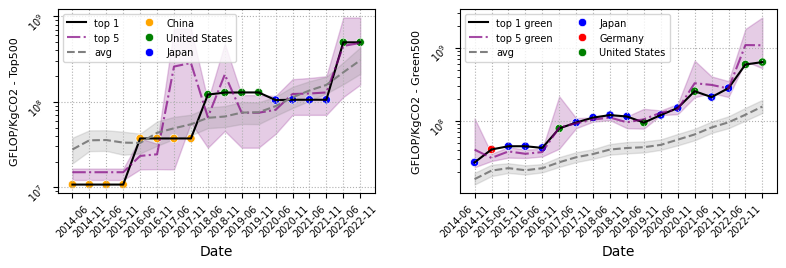

In [13]:
# Plotting : Evolution of the maximum performance in GFLOP per kgCO2 for the top 1 & 5 systems in the Top500 [Left] and Green500
# [right].
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 

plt.yscale('log')
plt.grid(linestyle='dotted')

## mean & max df
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] == 1]
log_df_5 = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]
log_df_mean = n_concat_df

g_log_df_max = n_concat_df[n_concat_df['Rank'] == 1]
g_log_df_5 = n_concat_df[n_concat_df['Rank'] <= 5]

## The top1 plots
sns.lineplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2', label='top 1', markers=True, color='black', ax=ax[0])
sns.lineplot(data=log_df_5, x='rank_year', y='GFlops/KgCO2', label='top 5', markers=True, color='purple', linestyle='-.', alpha=0.7, ax=ax[0])

## The mean plots
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='avg', markers=True, color='grey', linestyle='--', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2',  markers=True, hue='Country', ax=ax[0], palette=['orange', 'green', 'blue'])

## The top1 plots (green500)
sns.lineplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2', label='top 1 green', markers=True, color='black', ax=ax[1])
sns.lineplot(data=g_log_df_5, x='rank_year', y='GFlops/KgCO2', label='top 5 green', markers=True, color='purple', linestyle='-.', alpha=0.7, ax=ax[1])


## The mean plots (green500)
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='avg', markers=True, color='grey', linestyle='--', ax=ax[1])
sns.scatterplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2',  markers=True, hue='Country', ax=ax[1], palette=['blue', 'red', 'green'])

## Layout
plt.legend(ncol=2, loc=9, fontsize="7")
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()

# axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].set_yscale('log')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('GFLOP/KgCO2 - Top500', fontsize='8')
ax[1].set_ylabel('GFLOP/KgCO2 - Green500', fontsize='8')

figure.suptitle('', fontsize='9')
figure.subplots_adjust(top=0.88)

# To save the figure
plt.savefig('./figures/flops_per_kgco2.png', format="png", bbox_inches="tight")


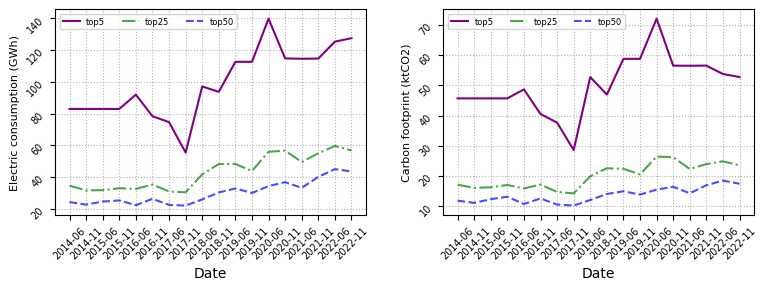

In [14]:
# Plotting : Electric consumption & carbon footprint for the top 5, 25, 50 in Top500 over time.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 

n_concat_df['Carbon footprint (ktCO2)'] = n_concat_df['Carbon footprint (TCO2)'] / 1e3
## mean & max df
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]
log_df_mean = n_concat_df

## The top1, 25 and 50 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top5', color='purple', ax=ax[0], ci=None)
ax[0] = sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 25], x='rank_year', y='electric_consumption (GWh)', label='top25', markers=True, color='green', ax=ax[0], alpha=0.7, ci=None, linestyle='dashdot')
ax[0] = sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 50], x='rank_year', y='electric_consumption (GWh)', label='top50', markers=True, color='blue', ax=ax[0], alpha=0.7, ci=None, linestyle='dashed')

ax[1] = sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (ktCO2)', label='top5', markers=False, color='purple', ax=ax[1], ci=None)
ax[1] = sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 25], x='rank_year', y='Carbon footprint (ktCO2)', label='top25', markers=True, color='green', ax=ax[1], alpha=0.7, ci=None, linestyle='dashdot')
ax[1] = sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 50], x='rank_year', y='Carbon footprint (ktCO2)', label='top50', markers=True, color='blue', ax=ax[1], alpha=0.7, ci=None, linestyle='dashed')

## Layout
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=3, loc=2, fontsize="6")
    
ax[0].set_ylabel('Electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (ktCO2)', fontsize='8')

figure.subplots_adjust(top=0.88)

# to save the figure
plt.savefig('./figures/top500_conso_co2.png', format='png', bbox_inches="tight")
